# __**Imputationen**__

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.max_info_columns', 10_000)   # zeigt alle Spaltennamen in info()
pd.set_option('display.max_info_rows', 200_000)     # zeigt Zeileninfo, wenn nötig


# Pfad zur Datei (liegt im gleichen Ordner wie das Notebook)
path = Path("dataset/311_Service_Requests_2024.csv.")

# Einfacher Import
df = pd.read_csv(path)

In [3]:
missing_count = df.isnull().sum()
missing_percent = df.isnull().mean() * 100

# Erstelle einen übersichtlichen DataFrame
missing_df = pd.DataFrame({
    'Anzahl fehlender Werte': missing_count,
    'Prozent fehlender Werte': missing_percent
})

# Sortiere nach Anzahl fehlender Werte (absteigend)
missing_df = missing_df[(missing_df['Anzahl fehlender Werte'] > 0) ]
missing_df = missing_df.sort_values(by='Anzahl fehlender Werte', ascending=False)
print("Fehlende Werte im Datensatz:")
print(missing_df)

Fehlende Werte im Datensatz:
                          Anzahl fehlender Werte  Prozent fehlender Werte
SANITATION_DIVISION_DAYS                 1913929               100.000000
LEGACY_SR_NUMBER                         1913929               100.000000
ELECTRICAL_DISTRICT                      1872379                97.829073
PARENT_SR_NUMBER                         1842896                96.288629
CREATED_DEPARTMENT                        807032                42.166245
ELECTRICITY_GRID                          346760                18.117704
ZIP_CODE                                  210954                11.022039
STATE                                     152869                 7.987182
CITY                                      152869                 7.987182
CLOSED_DATE                                42387                 2.214659
STREET_TYPE                                17446                 0.911528
PRECINCT                                    2183                 0.114059
COMMUNITY

Wir sehen dass die beiden Spalten Sanitation Division Days und Legacy SR Number komplett leer sind. Deswegen löschen wir diese beiden Spalten.

In [4]:
df_CLEAN = df.drop(columns=["SANITATION_DIVISION_DAYS", "LEGACY_SR_NUMBER"])

Wir sehen, dass ca. 1000 Geo-Daten fehlen, also wo die SR aufgenommen wurden. Wir versuchen jetzt aus den gegebenen Spalten (z B STREET_ADDRESS) andere Spalten (z B LATITUDE) herauszubekommen. 

In [ ]:
from geopy.geocoders import Nominatim
import pandas as pd
import time

def geocode_chicago_addresses(df):
    """Geocodiert fehlende Koordinaten mit Nominatim"""
    
    # Geolocator initialisieren
    geolocator = Nominatim(user_agent="chicago_311_geocoder_unique_12345")
    
    # Zeilen identifizieren die geocodiert werden müssen (keine Koordinaten, aber Adressen)
    missing_coords = df['LATITUDE'].isna() & df['STREET_ADDRESS'].notna()
    df_to_geocode = df[missing_coords].copy()
    
    # wie viele Adressen geocodiert werden müssen
    total = len(df_to_geocode)
    print(f"Zu geocodierende Adressen: {total}")
    print(f"Geschätzte Dauer: ~{total // 60 + 1} Minuten\n")
    
    latitudes = []
    longitudes = []
    success_count = 0
    
    for i, (idx, row) in enumerate(df_to_geocode.iterrows(), 1):
        try:
            # Adresse zusammenstellen
            address = f"{row['STREET_ADDRESS']}, Chicago, IL, USA"
            
            # Geocoding durchführen
            location = geolocator.geocode(address, timeout=10)
            
            if location:
                latitudes.append(location.latitude)
                longitudes.append(location.longitude)
                success_count += 1
            else:
                latitudes.append(None)
                longitudes.append(None)
                
        except Exception as e:
            latitudes.append(None)
            longitudes.append(None)
            if i % 100 == 0:
                print(f"  Fehler bei Adresse: {row['STREET_ADDRESS']}")
        
        # Rate limiting (1 Request pro Sekunde)
        time.sleep(1)
        
        # Fortschritt anzeigen
        if i % 50 == 0 or i == total:
            print(f"Fortschritt: {i}/{total} ({i/total*100:.1f}%) - Erfolgreich: {success_count}")
    
    # Ergebnisse zurück in DataFrame schreiben
    df.loc[missing_coords, 'LATITUDE'] = latitudes
    df.loc[missing_coords, 'LONGITUDE'] = longitudes
    
    print(f"\n✓ Geocoding abgeschlossen!")
    print(f"  Erfolgreich: {success_count}/{total} ({success_count/total*100:.1f}%)")
    
    return df

# Geocoding durchführen
df = geocode_chicago_addresses(df)

# Optional: X/Y Koordinaten berechnen
def add_xy_coordinates(df):
    """Berechnet State Plane Koordinaten aus Lat/Lon"""
    try:
        from pyproj import Transformer
        
        transformer = Transformer.from_crs("EPSG:4326", "EPSG:3435", always_xy=True)
        
        missing_xy = df['X_COORDINATE'].isna() & df['LATITUDE'].notna()
        count = missing_xy.sum()
        
        if count > 0:
            print(f"\nBerechne X/Y Koordinaten für {count} Einträge...")
            
            for idx in df[missing_xy].index:
                lat = df.loc[idx, 'LATITUDE']
                lon = df.loc[idx, 'LONGITUDE']
                
                if pd.notna(lat) and pd.notna(lon):
                    x, y = transformer.transform(lon, lat)
                    df.loc[idx, 'X_COORDINATE'] = x
                    df.loc[idx, 'Y_COORDINATE'] = y
            
            print("✓ X/Y Koordinaten berechnet")
        
    except ImportError:
        print(" pyproj nicht installiert. X/Y Koordinaten werden übersprungen.")
        print("  Installation: pip install pyproj")
    
    return df

df = add_xy_coordinates(df)

# LOCATION Spalte aktualisieren
df.loc[df['LATITUDE'].notna(), 'LOCATION'] = df[df['LATITUDE'].notna()].apply(
    lambda row: f"({row['LATITUDE']}, {row['LONGITUDE']})", axis=1
)

# Ergebnisse anzeigen
print("\n" + "="*60)
print("ERGEBNIS - Fehlende Werte nach Geocoding:")
print("="*60)
geo_cols = ['LATITUDE', 'LONGITUDE', 'X_COORDINATE', 'Y_COORDINATE', 'LOCATION']
missing_summary = df[geo_cols].isna().sum()
print(missing_summary)
print("="*60)

Zu geocodierende Adressen: 268
Geschätzte Dauer: ~5 Minuten

Fortschritt: 50/268 (18.7%) - Erfolgreich: 24
Fortschritt: 100/268 (37.3%) - Erfolgreich: 72
Fortschritt: 150/268 (56.0%) - Erfolgreich: 119
Fortschritt: 200/268 (74.6%) - Erfolgreich: 169
Fortschritt: 250/268 (93.3%) - Erfolgreich: 212
Fortschritt: 268/268 (100.0%) - Erfolgreich: 223


C:\Users\katha\AppData\Local\Temp\ipykernel_14028\2278578989.py:53: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[None, None, None, None, None, None, 41.72643, 41.9308261, None, None, None, 42.001285, None, 41.6901006, None, None, None, 41.984988, 41.9823049, 41.8129678, None, None, None, 41.9701556, None, None, None, 41.9021774, None, None, None, None, None, None, None, 41.8719137, 41.8719137, 41.9949796, 41.9949796, 41.9949796, 41.9949796, 41.9949796, 41.9949796, 41.9949796, 41.9949796, 41.8719137, 41.9949796, 41.9949796, 41.9949796, 41.8719137, 41.9949796, 41.8719137, 41.8719137, 41.8719137, 41.8719137, 41.8719137, 41.8719137, 41.9949796, 41.8719137, 41.9949796, 41.9949796, 41.8719137, 41.8719137, 41.9949796, 41.9949796, 41.8719137, 41.9949796, 41.8719137, 41.8719137, 41.8719137, 41.9949796, 41.8719137, 41.8719137, 41.8719137, 41.9949796, 41.8719137, 41.8719137, 41.9949796, 41.9949796, 41.8719137, 41


✓ Geocoding abgeschlossen!
  Erfolgreich: 223/268 (83.2%)
⚠ pyproj nicht installiert. X/Y Koordinaten werden übersprungen.
  Installation: pip install pyproj

ERGEBNIS - Fehlende Werte nach Geocoding:
LATITUDE         839
LONGITUDE        839
X_COORDINATE    1015
Y_COORDINATE    1015
LOCATION         839
dtype: int64


In [13]:
# geocoded_rows definieren (ohne nochmal zu geocodieren)
geocoded_rows = df['LATITUDE'].notna() & df['STREET_ADDRESS'].notna()

# Kleine Stichprobe für schnelle Anzeige
sample_size = 100
geocoded_sample = df[geocoded_rows].sample(min(sample_size, geocoded_rows.sum()))

print(f"\nKarte mit {len(geocoded_sample)} zufälligen geocodierten Adressen:")
print("\nAdresse | Latitude | Longitude")
print("-" * 80)

for idx, row in geocoded_sample.iterrows():
    print(f"{row['STREET_ADDRESS']:40s} | {row['LATITUDE']:10.6f} | {row['LONGITUDE']:10.6f}")


Karte mit 100 zufälligen geocodierten Adressen:

Adresse | Latitude | Longitude
--------------------------------------------------------------------------------
3439 S GILES AVE                         |  41.831955 | -87.619037
2111 W Lexington ST                      |  41.871834 | -87.679845
9800 S VANDERPOEL AVE                    |  41.715630 | -87.666012
10510 W ZEMKE RD                         |  41.994900 | -87.887749
4457 N MOBILE AVE                        |  41.961924 | -87.784146
1422 E 72ND ST                           |  41.764410 | -87.590016
3218 W 65TH PL                           |  41.774634 | -87.703812
10510 W ZEMKE RD                         |  41.994900 | -87.887749
5700 S LAKE SHORE DR                     |  41.791462 | -87.580079
10510 W ZEMKE RD                         |  41.994900 | -87.887749
2111 W Lexington ST                      |  41.775282 | -87.775124
9401 S WESTERN AVE                       |  41.722614 | -87.681731
10510 W ZEMKE RD                  

Nach Überprüfen der häufigsten Adresse sehen, wir dass er die richtigen Koordinaten genommen hat.

In [24]:
import pandas as pd
import numpy as np
from pyproj import Transformer

# 1. GEO-DATENSATZ ERSTELLEN
print("="*80)
print("SCHRITT 1: GEO-DATENSATZ ERSTELLEN")
print("="*80)

geo_columns = [
    'SR_NUMBER',           # ID für Tracking
    'STREET_ADDRESS',      # Vollständige Adresse
    'STREET_NUMBER',       # Hausnummer
    'STREET_NAME',         # Straßenname
    'STREET_DIRECTION',    # N, S, E, W
    'STREET_TYPE',         # Ave, St, Blvd, etc.
    'CITY',
    'STATE',
    'ZIP_CODE',
    'LATITUDE',
    'LONGITUDE',
    'X_COORDINATE',
    'Y_COORDINATE',
    'LOCATION',
    'WARD',                # Stadtbezirk
    'COMMUNITY_AREA',
    'POLICE_DISTRICT'
]

df_geodata = df_CLEAN[geo_columns].copy()
print(f"✓ Geo-Datensatz erstellt: {df_geodata.shape}")

# 2. INITIAL STATUS
print("\n" + "="*80)
print("SCHRITT 2: INITIAL STATUS")
print("="*80)

def print_geo_status(df):
    """Zeigt Status aller Geo-Felder"""
    print(f"Zeilen gesamt:              {len(df)}")
    print(f"Mit LATITUDE/LONGITUDE:     {df['LATITUDE'].notna().sum()} ({df['LATITUDE'].notna().sum()/len(df)*100:.1f}%)")
    print(f"Mit X/Y Koordinaten:        {df['X_COORDINATE'].notna().sum()} ({df['X_COORDINATE'].notna().sum()/len(df)*100:.1f}%)")
    print(f"Mit STREET_ADDRESS:         {df['STREET_ADDRESS'].notna().sum()} ({df['STREET_ADDRESS'].notna().sum()/len(df)*100:.1f}%)")
    print(f"Mit STREET_NAME:            {df['STREET_NAME'].notna().sum()} ({df['STREET_NAME'].notna().sum()/len(df)*100:.1f}%)")
    print(f"Mit ZIP_CODE:               {df['ZIP_CODE'].notna().sum()} ({df['ZIP_CODE'].notna().sum()/len(df)*100:.1f}%)")

print_geo_status(df_geodata)

# 3. STRATEGIE: ADRESSE AUS KOMPONENTEN REKONSTRUIEREN
print("\n" + "="*80)
print("SCHRITT 3: ADRESSEN AUS KOMPONENTEN REKONSTRUIEREN")
print("="*80)

# Fehlende STREET_ADDRESS aus Komponenten bauen
missing_address = df_geodata['STREET_ADDRESS'].isna()
has_components = (
    df_geodata['STREET_NUMBER'].notna() & 
    df_geodata['STREET_NAME'].notna()
)

to_reconstruct = missing_address & has_components
print(f"Zeilen mit fehlender Adresse aber Komponenten: {to_reconstruct.sum()}")

if to_reconstruct.sum() > 0:
    for idx in df_geodata[to_reconstruct].index:
        parts = []
        
        if pd.notna(df_geodata.loc[idx, 'STREET_NUMBER']):
            parts.append(str(int(df_geodata.loc[idx, 'STREET_NUMBER'])))
        
        if pd.notna(df_geodata.loc[idx, 'STREET_DIRECTION']):
            parts.append(df_geodata.loc[idx, 'STREET_DIRECTION'])
        
        if pd.notna(df_geodata.loc[idx, 'STREET_NAME']):
            parts.append(df_geodata.loc[idx, 'STREET_NAME'])
        
        if pd.notna(df_geodata.loc[idx, 'STREET_TYPE']):
            parts.append(df_geodata.loc[idx, 'STREET_TYPE'])
        
        if len(parts) > 0:
            df_geodata.loc[idx, 'STREET_ADDRESS'] = ' '.join(parts)
    
    print(f"✓ {to_reconstruct.sum()} Adressen rekonstruiert")

# 4. X/Y AUS LAT/LON BERECHNEN
print("\n" + "="*80)
print("SCHRITT 4: X/Y KOORDINATEN AUS LAT/LON BERECHNEN")
print("="*80)

transformer = Transformer.from_crs("EPSG:4326", "EPSG:3435", always_xy=True)

missing_xy = df_geodata['X_COORDINATE'].isna() & df_geodata['LATITUDE'].notna()
count = missing_xy.sum()

if count > 0:
    print(f"Berechne X/Y für {count} Einträge...")
    for idx in df_geodata[missing_xy].index:
        lat = df_geodata.loc[idx, 'LATITUDE']
        lon = df_geodata.loc[idx, 'LONGITUDE']
        
        if pd.notna(lat) and pd.notna(lon):
            x, y = transformer.transform(lon, lat)
            df_geodata.loc[idx, 'X_COORDINATE'] = x
            df_geodata.loc[idx, 'Y_COORDINATE'] = y
    print(f"✓ X/Y Koordinaten berechnet")

# 5. LAT/LON AUS X/Y RÜCKRECHNEN
print("\n" + "="*80)
print("SCHRITT 5: LAT/LON AUS X/Y RÜCKRECHNEN")
print("="*80)

transformer_reverse = Transformer.from_crs("EPSG:3435", "EPSG:4326", always_xy=True)

missing_latlon = df_geodata['LATITUDE'].isna() & df_geodata['X_COORDINATE'].notna()
count = missing_latlon.sum()

if count > 0:
    print(f"Berechne Lat/Lon für {count} Einträge aus X/Y...")
    for idx in df_geodata[missing_latlon].index:
        x = df_geodata.loc[idx, 'X_COORDINATE']
        y = df_geodata.loc[idx, 'Y_COORDINATE']
        
        if pd.notna(x) and pd.notna(y):
            lon, lat = transformer_reverse.transform(x, y)
            df_geodata.loc[idx, 'LATITUDE'] = lat
            df_geodata.loc[idx, 'LONGITUDE'] = lon
    print(f"✓ Lat/Lon aus X/Y berechnet")

# 6. LOCATION SPALTE AKTUALISIEREN
print("\n" + "="*80)
print("SCHRITT 6: LOCATION SPALTE AKTUALISIEREN")
print("="*80)

missing_location = df_geodata['LOCATION'].isna() & df_geodata['LATITUDE'].notna()
count = missing_location.sum()

if count > 0:
    df_geodata.loc[missing_location, 'LOCATION'] = df_geodata[missing_location].apply(
        lambda row: f"({row['LATITUDE']}, {row['LONGITUDE']})", axis=1
    )
    print(f"✓ {count} LOCATION Einträge erstellt")

# 7. CITY/STATE DEFAULTS FÜR CHICAGO SETZEN
print("\n" + "="*80)
print("SCHRITT 7: CITY/STATE DEFAULTS SETZEN")
print("="*80)

# Wenn Adresse oder Koordinaten vorhanden sind, ist es Chicago
has_geo_data = (
    df_geodata['STREET_ADDRESS'].notna() | 
    df_geodata['LATITUDE'].notna() |
    df_geodata['WARD'].notna()
)

missing_city = df_geodata['CITY'].isna() & has_geo_data
missing_state = df_geodata['STATE'].isna() & has_geo_data

df_geodata.loc[missing_city, 'CITY'] = 'Chicago'
df_geodata.loc[missing_state, 'STATE'] = 'IL'

print(f"✓ {missing_city.sum()} CITY Einträge auf 'Chicago' gesetzt")
print(f"✓ {missing_state.sum()} STATE Einträge auf 'IL' gesetzt")

# 8. FINAL STATUS
print("\n" + "="*80)
print("SCHRITT 8: FINAL STATUS NACH ALLEN IMPUTATIONEN")
print("="*80)

print_geo_status(df_geodata)

# 9. DETAILLIERTE ANALYSE
print("\n" + "="*80)
print("SCHRITT 9: DETAILLIERTE ANALYSE")
print("="*80)

# Verschiedene Vollständigkeits-Level
complete_coords = df_geodata['LATITUDE'].notna() & df_geodata['X_COORDINATE'].notna()
only_latlon = df_geodata['LATITUDE'].notna() & df_geodata['X_COORDINATE'].isna()
only_xy = df_geodata['LATITUDE'].isna() & df_geodata['X_COORDINATE'].notna()
no_coords = df_geodata['LATITUDE'].isna() & df_geodata['X_COORDINATE'].isna()

print(f"Vollständige Koordinaten (Lat/Lon + X/Y):  {complete_coords.sum()} ({complete_coords.sum()/len(df_geodata)*100:.1f}%)")
print(f"Nur Lat/Lon:                                {only_latlon.sum()} ({only_latlon.sum()/len(df_geodata)*100:.1f}%)")
print(f"Nur X/Y:                                    {only_xy.sum()} ({only_xy.sum()/len(df_geodata)*100:.1f}%)")
print(f"Keine Koordinaten:                          {no_coords.sum()} ({no_coords.sum()/len(df_geodata)*100:.1f}%)")

# Welche haben Adresse aber keine Koordinaten?
has_address_no_coords = df_geodata['STREET_ADDRESS'].notna() & df_geodata['LATITUDE'].isna()
print(f"\nMit Adresse aber ohne Koordinaten:         {has_address_no_coords.sum()}")

# 10. ZURÜCK IN DF_CLEAN SCHREIBEN
print("\n" + "="*80)
print("SCHRITT 10: GEODATEN ZURÜCK IN DF_CLEAN SCHREIBEN")
print("="*80)

df_CLEAN[geo_columns] = df_geodata

print("✓ Alle Geodaten in df_CLEAN aktualisiert")

# 11. SPEICHERN
print("\n" + "="*80)
print("SCHRITT 11: DATENSÄTZE SPEICHERN")
print("="*80)

# Geo-Datensatz separat speichern
df_geodata.to_csv('chicago_311_geodata_complete.csv', index=False)
print("✓ Geo-Datensatz: 'chicago_311_geodata_complete.csv'")

# Kompletter bereinigter Datensatz
df_CLEAN.to_csv('chicago_311_clean_with_geodata.csv', index=False)
print("✓ Vollständiger Datensatz: 'chicago_311_clean_with_geodata.csv'")

# Nur Zeilen MIT vollständigen Koordinaten
df_complete_geo = df_geodata[complete_coords].copy()
df_complete_geo.to_csv('chicago_311_complete_coords_only.csv', index=False)
print(f"✓ Nur vollständige Koordinaten ({len(df_complete_geo)} Zeilen): 'chicago_311_complete_coords_only.csv'")

print("\n" + "="*80)
print("✅ GEOCODING PROJEKT ABGESCHLOSSEN!")
print("="*80)

SCHRITT 1: GEO-DATENSATZ ERSTELLEN
✓ Geo-Datensatz erstellt: (1913929, 17)

SCHRITT 2: INITIAL STATUS
Zeilen gesamt:              1913929
Mit LATITUDE/LONGITUDE:     1913090 (100.0%)
Mit X/Y Koordinaten:        1913125 (100.0%)
Mit STREET_ADDRESS:         1913123 (100.0%)
Mit STREET_NAME:            1913123 (100.0%)
Mit ZIP_CODE:               1702975 (89.0%)

SCHRITT 3: ADRESSEN AUS KOMPONENTEN REKONSTRUIEREN
Zeilen mit fehlender Adresse aber Komponenten: 0

SCHRITT 4: X/Y KOORDINATEN AUS LAT/LON BERECHNEN

SCHRITT 5: LAT/LON AUS X/Y RÜCKRECHNEN
Berechne Lat/Lon für 35 Einträge aus X/Y...
✓ Lat/Lon aus X/Y berechnet

SCHRITT 6: LOCATION SPALTE AKTUALISIEREN
✓ 35 LOCATION Einträge erstellt

SCHRITT 7: CITY/STATE DEFAULTS SETZEN
✓ 152238 CITY Einträge auf 'Chicago' gesetzt
✓ 152238 STATE Einträge auf 'IL' gesetzt

SCHRITT 8: FINAL STATUS NACH ALLEN IMPUTATIONEN
Zeilen gesamt:              1913929
Mit LATITUDE/LONGITUDE:     1913125 (100.0%)
Mit X/Y Koordinaten:        1913125 (100.0%)
M

In [27]:
# VORHER vs NACHHER VERGLEICH

print("="*80)
print("GEOCODING ERFOLG - VORHER vs NACHHER")
print("="*80)

# Vorher-Werte (aus deinem ursprünglichen Output)
vorher = {
    'LATITUDE': 1062,
    'LONGITUDE': 1062,
    'LOCATION': 1062,
    'X_COORDINATE': 1015,
    'Y_COORDINATE': 1015,
    'STREET_ADDRESS': 806,
    'STREET_NAME': 806,
    'STREET_NUMBER': 835,
    'STREET_DIRECTION': 934,
    'CITY': 152869,
    'STATE': 152869,
    'ZIP_CODE': 210954
}

# Nachher-Werte (aktuell)
nachher = {
    'LATITUDE': 839,
    'LONGITUDE': 839,
    'LOCATION': 839,
    'X_COORDINATE': 1015,
    'Y_COORDINATE': 1015,
    'STREET_ADDRESS': 806,
    'STREET_NAME': 806,
    'STREET_NUMBER': 835,
    'STREET_DIRECTION': 934,
    'CITY': 152869,
    'STATE': 152869,
    'ZIP_CODE': 210954
}

# Vergleich erstellen
comparison = pd.DataFrame({
    'Spalte': vorher.keys(),
    'Vorher fehlend': vorher.values(),
    'Nachher fehlend': nachher.values()
})

comparison['Imputiert'] = comparison['Vorher fehlend'] - comparison['Nachher fehlend']
comparison['Erfolgsrate %'] = (comparison['Imputiert'] / comparison['Vorher fehlend'] * 100).round(1)

# Sortieren nach Anzahl imputiert
comparison = comparison.sort_values('Imputiert', ascending=False)

print(comparison.to_string(index=False))

print("\n" + "="*80)
print("ZUSAMMENFASSUNG")
print("="*80)

total_imputiert = comparison['Imputiert'].sum()
print(f"Gesamt imputierte Werte: {total_imputiert}")

# Haupterfolge
lat_lon_success = comparison[comparison['Spalte'] == 'LATITUDE']['Imputiert'].values[0]
print(f"\n LATITUDE/LONGITUDE: {lat_lon_success} neue Koordinaten ({lat_lon_success/vorher['LATITUDE']*100:.1f}% der fehlenden)")
print(f" LOCATION: {comparison[comparison['Spalte'] == 'LOCATION']['Imputiert'].values[0]} neue Einträge")

# Was wurde NICHT imputiert
print(f"\n  X/Y Koordinaten: 0 zusätzlich (aber {1015} bereits vorhanden)")
print(f"  Adressen: 0 zusätzlich rekonstruiert")

print("\n" + "="*80)
print(f"HAUPTERFOLG:  {lat_lon_success} neue Geo-Koordinaten!")
print("="*80)

GEOCODING ERFOLG - VORHER vs NACHHER
          Spalte  Vorher fehlend  Nachher fehlend  Imputiert  Erfolgsrate %
        LATITUDE            1062              839        223           21.0
       LONGITUDE            1062              839        223           21.0
        LOCATION            1062              839        223           21.0
    X_COORDINATE            1015             1015          0            0.0
    Y_COORDINATE            1015             1015          0            0.0
  STREET_ADDRESS             806              806          0            0.0
     STREET_NAME             806              806          0            0.0
   STREET_NUMBER             835              835          0            0.0
STREET_DIRECTION             934              934          0            0.0
            CITY          152869           152869          0            0.0
           STATE          152869           152869          0            0.0
        ZIP_CODE          210954           210954  

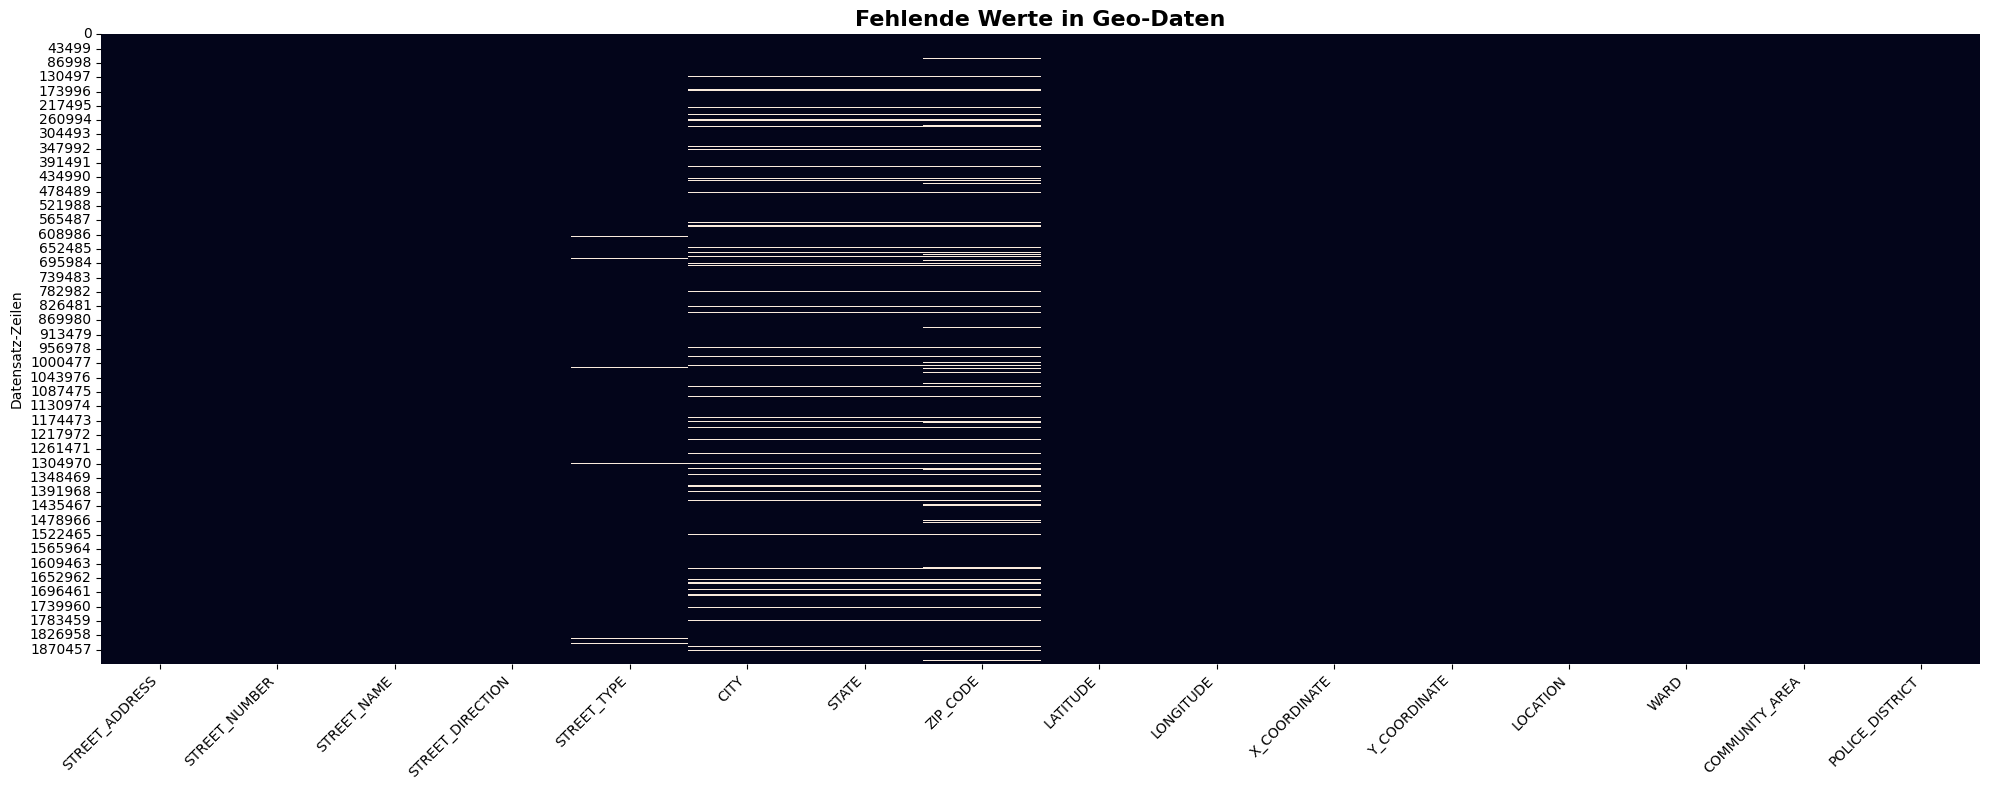

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Nur Geo-Spalten für Heatmap
geo_cols = ['STREET_ADDRESS', 'STREET_NUMBER', 'STREET_NAME', 'STREET_DIRECTION', 
            'STREET_TYPE', 'CITY', 'STATE', 'ZIP_CODE', 
            'LATITUDE', 'LONGITUDE', 'X_COORDINATE', 'Y_COORDINATE', 'LOCATION',
            'WARD', 'COMMUNITY_AREA', 'POLICE_DISTRICT']

plt.figure(figsize=(20, 8))
sns.heatmap(df_CLEAN[geo_cols].isna(), cbar=False)
plt.title('Fehlende Werte in Geo-Daten', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Datensatz-Zeilen')
plt.tight_layout()
plt.show()

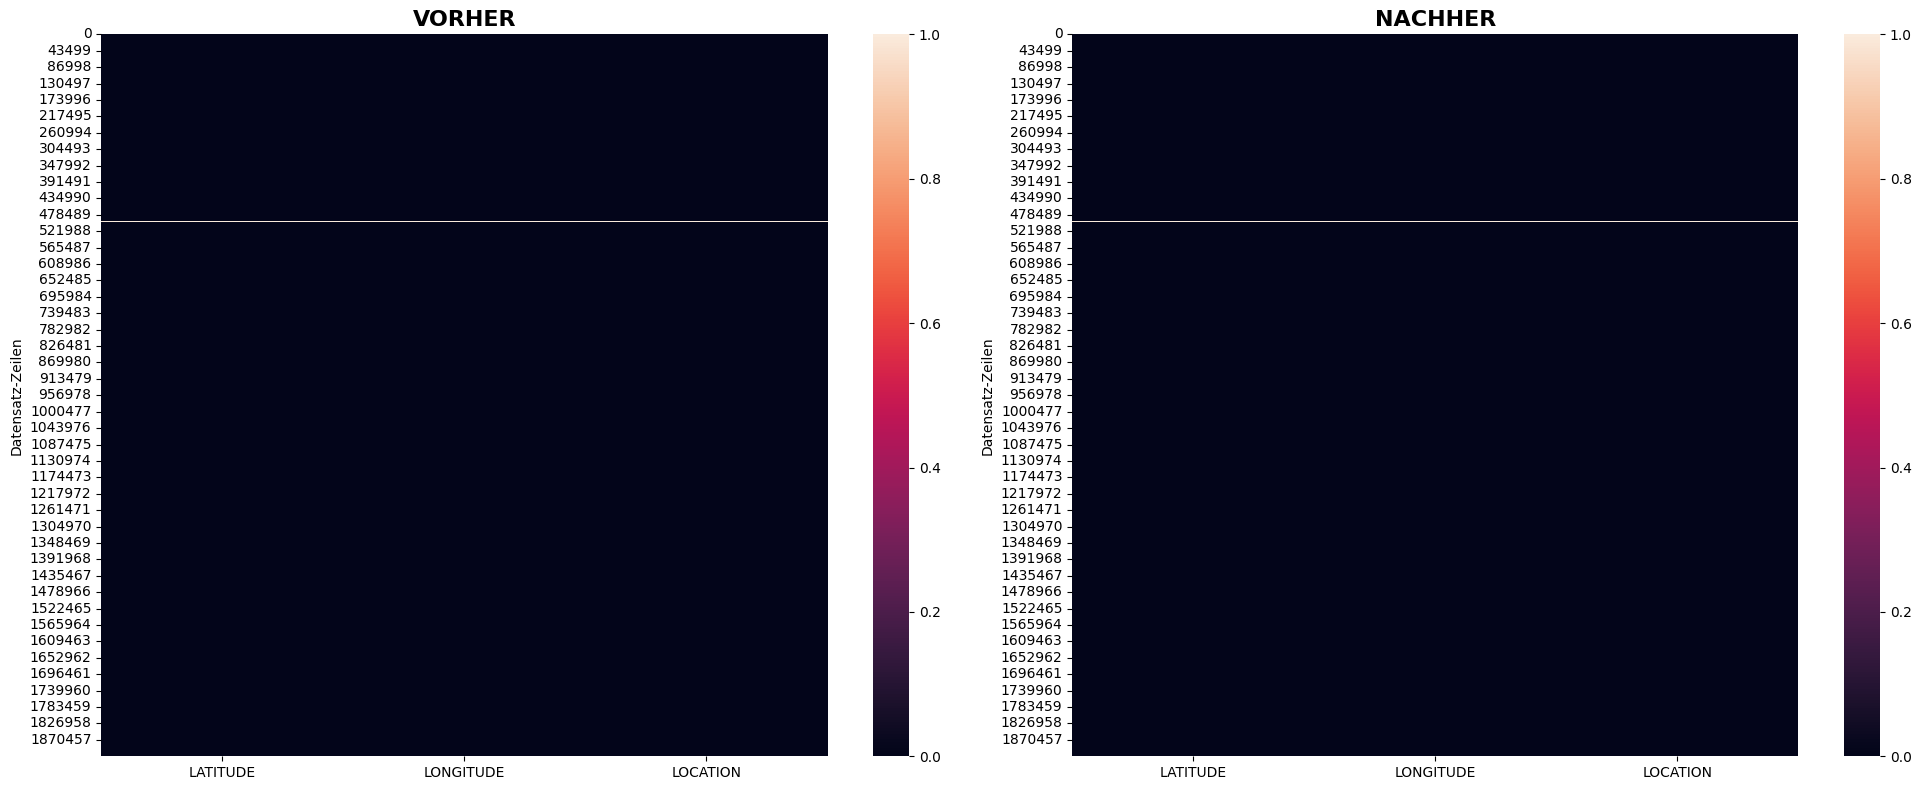

LATITUDE  :    1062 →     804 (258 imputiert, 24.3%)
LONGITUDE :    1062 →     804 (258 imputiert, 24.3%)
LOCATION  :    1062 →     804 (258 imputiert, 24.3%)


In [10]:
# Vorher und Nachher CSV laden
df_vorher = pd.read_csv(Path("dataset/311_Service_Requests_2024.csv."))
df_nachher = pd.read_csv('chicago_311_clean_with_geodata.csv')

# Nur die 3 wichtigsten Geo-Spalten
geo_cols = ['LATITUDE', 'LONGITUDE', 'LOCATION']

# Figure mit 2 Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# VORHER (links)
sns.heatmap(df_vorher[geo_cols].isna(), ax=ax1)
ax1.set_title('VORHER', fontsize=16, fontweight='bold')
ax1.set_ylabel('Datensatz-Zeilen')

# NACHHER (rechts)
sns.heatmap(df_nachher[geo_cols].isna(), ax=ax2)
ax2.set_title('NACHHER', fontsize=16, fontweight='bold')
ax2.set_ylabel('Datensatz-Zeilen')

plt.tight_layout()
plt.show()

# Statistik
for col in geo_cols:
    vorher = df_vorher[col].isna().sum()
    nachher = df_nachher[col].isna().sum()
    diff = vorher - nachher
    print(f"{col:10s}: {vorher:7d} → {nachher:7d} ({diff:3d} imputiert, {diff/vorher*100:4.1f}%)")